In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/samsum-dataset-text-summarization/samsum-train.csv
/kaggle/input/samsum-dataset-text-summarization/samsum-test.csv
/kaggle/input/samsum-dataset-text-summarization/samsum-validation.csv
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/dataset_dict.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/validation/state.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/validation/dataset_info.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/validation/data-00000-of-00001.arrow
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/test/state.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/test/dataset_info.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/test/data-00000-of-00001.arrow
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/train/state.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/train/dataset_info.json
/kaggle/input/sam

In [21]:
!pip install transformers datasets evaluate rouge_score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [22]:
# Transformers
#from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data 
import torch                                                              # PyTorch
import evaluate                                                           # Hugging Face's library for model evaluation


# Other NLP libraries
from textblob import TextBlob                                             # This is going to help us fix spelling mistakes in texts
from sklearn.feature_extraction.text import TfidfVectorizer               # This is going to helps identify the most common terms in the corpus
import re                                                                 # This library allows us to clean text data
import nltk                                                               # Natural Language Toolkit
nltk.download('punkt')                                                    # This divides a text into a list of sentences

import seaborn as sns


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


* TPU: Generally the fastest for training large-scale models due to its optimization for tensor operations. Well-optimized for TensorFlow.
* GPU: Fast for parallel processing and commonly used for deep learning tasks.
* CPU: The slowest for these tasks, more suited for general-purpose computations.

In [23]:
# Use GPU if available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is available. 
Using GPU


# Explorative Data Analysis and Data Cleaning

In [24]:
# Loading data
train = pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-train.csv')
val = pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-validation.csv')
test = pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-test.csv')

In machine learning, the training, validation, and test sets serve different purposes:

* **Training set**: This is the dataset used to train the model, allowing it to learn patterns, relationships, and features from the data.
* **Validation set**: This dataset is used during training to tune model parameters and make adjustments, helping to prevent overfitting and optimize performance before evaluating on the test set.
* **Test set**: This is a separate dataset used to evaluate the model's performance after training, providing an unbiased measure of its accuracy and generalization on unseen data.

In [25]:
#Display the first 5 rows of the training set
train.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-),Amanda baked cookies and will bring Jerry some tomorrow.
1,13728867,Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great,Olivia and Olivier are voting for liberals in this election.
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style",Kim may try the pomodoro technique recommended by Tim to get more stuff done.
3,13730747,"Edward: Rachel, I think I'm in ove with Bella..\r\nrachel: Dont say anything else..\r\nEdward: What do you mean??\r\nrachel: Open your fu**ing door.. I'm outside",Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside.
4,13728094,"Sam: hey overheard rick say something\r\nSam: i don't know what to do :-/\r\nNaomi: what did he say??\r\nSam: he was talking on the phone with someone\r\nSam: i don't know who\r\nSam: and he was telling them that he wasn't very happy here\r\nNaomi: damn!!!\r\nSam: he was saying he doesn't like being my roommate\r\nNaomi: wow, how do you feel about it?\r\nSam: i thought i was a good rommate\r\nSam: and that we have a nice place\r\nNaomi: that's true man!!!\r\nNaomi: i used to love living with you before i moved in with me boyfriend\r\nNaomi: i don't know why he's saying that\r\nSam: what should i do???\r\nNaomi: honestly if it's bothering you that much you should talk to him\r\nNaomi: see what's going on\r\nSam: i don't want to get in any kind of confrontation though\r\nSam: maybe i'll just let it go\r\nSam: and see how it goes in the future\r\nNaomi: it's your choice sam\r\nNaomi: if i were you i would just talk to him and clear the air","Sam is confused, because he overheard Rick complaining about him as a roommate. Naomi thinks Sam should talk to Rick. Sam is not sure what to do."


In [26]:
train.describe()

,id,dialogue,summary
count,14732,14731,14732
unique,14732,14264,14730
top,13729017,"Jimmy: Hey, guess what? My car's completely kaput!\r\nCarrie: What happened?\r\nJimmy: Don't know, either the battery, alternator, engine or a combination of all three\r\nCarrie: Where is it now?\r\nJimmy: Yesterday I managed to jump-start it and it was fine, but then Amy took the car and stopped to get something at the store, and then she couldn't get it to start again\r\nCarrie: Sucks! Wanna borrow my Mercedes?\r\nJimmy: How are you gonna get it to me? You live so far from the city now\r\nCarrie: I don't live that far! It's only like 20 km\r\nJimmy: I'll let you know\r\nCarrie: I can drive it into the city, and then you can drive me back home, then you'll have the car :)\r\nJimmy: :) Hmm… I still gotta do something about my car\r\nCarrie: Actually, you should buy mine and get rid of yours\r\nJimmy: :-/ Yeah, lately there's always something with it. Anyways, I'll let you know. I may need it, Amy's sister is coming to visit.\r\nCarrie: Ok, see ya\r\nJimmy: Bye",Seth's pet Oreo that he got when he was 10 is feeling worse and they're thinking of putting him down. Tim is busy at work and Susan is on a business trip to Vienna.
freq,1,4,2


There are 14,732 rows in the train dataset, but only 14,731 dialogues. This indicates that there is a null value in the 'dialogue' column. Let’s inspect the data to identify and handle the missing values, as they can affect the model’s training process.

In [27]:
# Filtering the table for null dialogues
filtered_train = train[train['dialogue'].isnull()]
filtered_train

,id,dialogue,summary
6054,13828807,NaN,problem with visualization of the content


In [28]:
#Remove the missing row from the table
train = train.dropna()
train.describe()

,id,dialogue,summary
count,14731,14731,14731
unique,14731,14264,14729
top,13729017,"Jimmy: Hey, guess what? My car's completely kaput!\r\nCarrie: What happened?\r\nJimmy: Don't know, either the battery, alternator, engine or a combination of all three\r\nCarrie: Where is it now?\r\nJimmy: Yesterday I managed to jump-start it and it was fine, but then Amy took the car and stopped to get something at the store, and then she couldn't get it to start again\r\nCarrie: Sucks! Wanna borrow my Mercedes?\r\nJimmy: How are you gonna get it to me? You live so far from the city now\r\nCarrie: I don't live that far! It's only like 20 km\r\nJimmy: I'll let you know\r\nCarrie: I can drive it into the city, and then you can drive me back home, then you'll have the car :)\r\nJimmy: :) Hmm… I still gotta do something about my car\r\nCarrie: Actually, you should buy mine and get rid of yours\r\nJimmy: :-/ Yeah, lately there's always something with it. Anyways, I'll let you know. I may need it, Amy's sister is coming to visit.\r\nCarrie: Ok, see ya\r\nJimmy: Bye",Seth's pet Oreo that he got when he was 10 is feeling worse and they're thinking of putting him down. Tim is busy at work and Susan is on a business trip to Vienna.
freq,1,4,2


In [29]:
#Check the Test Set for null values
test.describe()

,id,dialogue,summary
count,819,819,819
unique,819,819,819
top,13818810,"Rachel: <file_other>\r\nRachel: Top 50 Best Films of 2018\r\nRachel: :)\r\nJanice: Omg, I've watched almost all 50... xDD\r\nSpencer: Hahah, Deadpool 2 also??\r\nJanice: Yep\r\nSpencer: Really??\r\nJanice: My bf forced me to watch it xD\r\nRachel: Hahah\r\nJanice: It wasn't that bad\r\nJanice: I thought it'd be worse\r\nRachel: And Avengers? :D\r\nJanice: 2 times\r\nRachel: Omg\r\nJanice: xP\r\nRachel: You are the best gf in the world\r\nRachel: Your bf should appreciate that ;-)\r\nJanice: He does\r\nJanice: x)","Rachel sends a list of Top 50 films of 2018. Janice watched almost half of them, Deadpool 2 and Avengers included."
freq,1,1,1


In [30]:
#Check the Validation Set for null values
val.describe()

,id,dialogue,summary
count,818,818,818
unique,818,818,818
top,13862383,"Paige: I asked them to wait and send the declaration later\nPaige: Even end of March if it's possible\nMaddy: What did they say?\nPaige: They want to close it asap cause Lisa is afraid she forgets about it later\nPaige: But I can remind her in a couple of weeks\nPaige: It's my responsibility after all\nMaddy: But does it really matter? I mean the declaration\nMaddy: I think the deadline for payment is 31 March anyway\nPaige: I'm not sure, that's what I asked her\nPaige: Hope she confirms",Paige wants to have the declaration sent later. Lisa wants to send it soon. The deadline for payment is 31 March.
freq,1,1,1


### Simple EDA 
Let's visualizes the distribution of dialogue and summary lengths in the data sets:

Text(0.5, 1.0, 'Message Lengths for the Training Set')

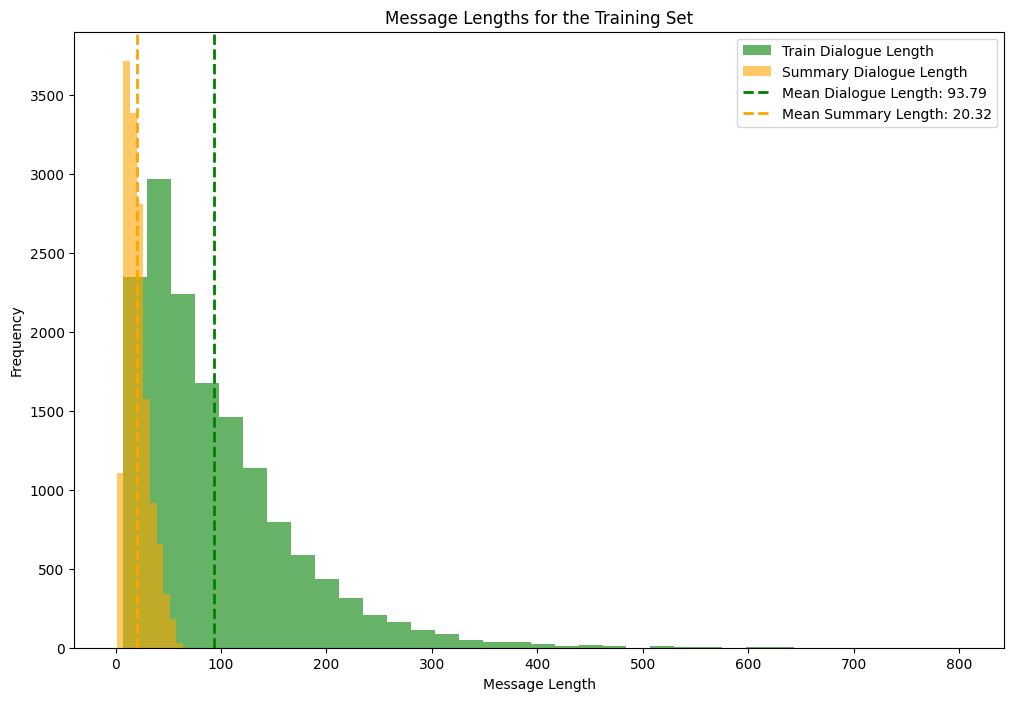

In [31]:
#Calculate text length
train_dialogue_length = train['dialogue'].apply(lambda x: len(x.split()))  
train_summary_length = train['summary'].apply(lambda x: len(x.split()))    

plt.figure(figsize=(12, 8))
train_dialogue_length.plot(bins=35, kind='hist', color='green', 
                                       label='Train Dialogue Length', alpha=0.6)
train_summary_length.plot(kind='hist', color='orange', 
                                       label='Summary Dialogue Length', alpha=0.6)

# Add mean lines
mean_dialogue_length = train_dialogue_length.mean()
mean_summary_length = train_summary_length.mean()

plt.axvline(mean_dialogue_length, color='green', linestyle='dashed', linewidth=2, label=f'Mean Dialogue Length: {mean_dialogue_length:.2f}')
plt.axvline(mean_summary_length, color='orange', linestyle='dashed', linewidth=2, label=f'Mean Summary Length: {mean_summary_length:.2f}')

plt.legend()
plt.xlabel("Message Length")
plt.title("Message Lengths for the Training Set")

Text(0.5, 1.0, 'Message Lengths for the Validation Set')

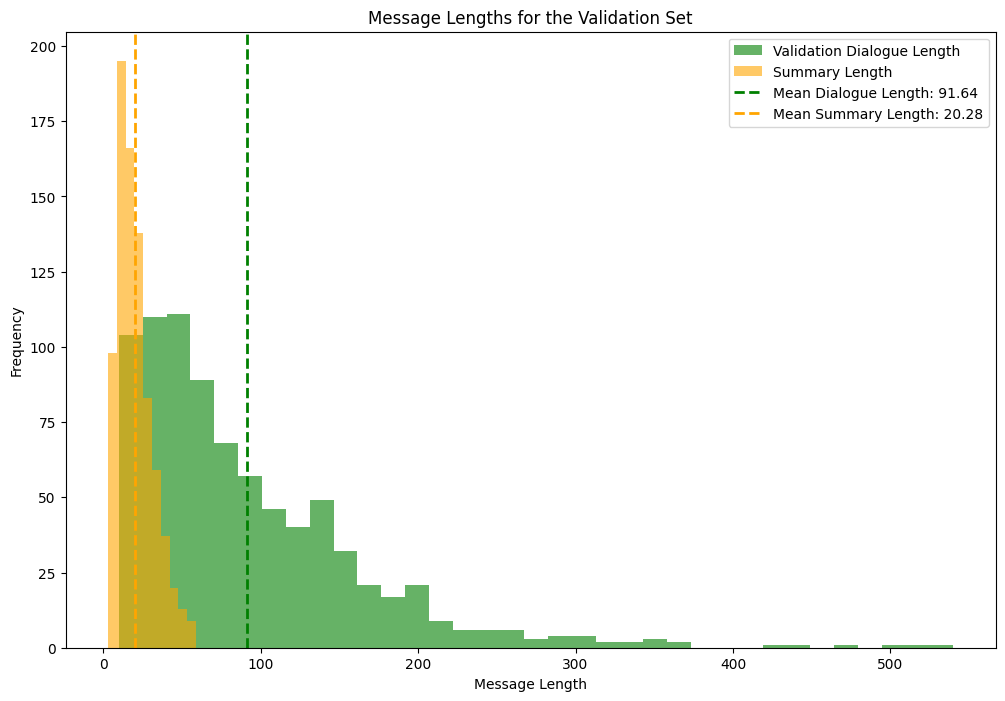

In [32]:
val_dialogue_length = val['dialogue'].apply(lambda x: len(x.split()))  # Length in words
val_summary_length = val['summary'].apply(lambda x: len(x.split()))    # Length in words

plt.figure(figsize=(12, 8))
val_dialogue_length.plot(bins=35, kind='hist', color='green', 
                          label='Validation Dialogue Length', alpha=0.6)
val_summary_length.plot(kind='hist', color='orange', 
                          label='Summary Length', alpha=0.6)

# Add mean lines
mean_dialogue_length = val_dialogue_length.mean()
mean_summary_length = val_summary_length.mean()

plt.axvline(mean_dialogue_length, color='green', linestyle='dashed', linewidth=2, label=f'Mean Dialogue Length: {mean_dialogue_length:.2f}')
plt.axvline(mean_summary_length, color='orange', linestyle='dashed', linewidth=2, label=f'Mean Summary Length: {mean_summary_length:.2f}')

plt.legend()
plt.xlabel("Message Length")
plt.title("Message Lengths for the Validation Set")

Text(0.5, 1.0, 'Message Lengths for the Test Set')

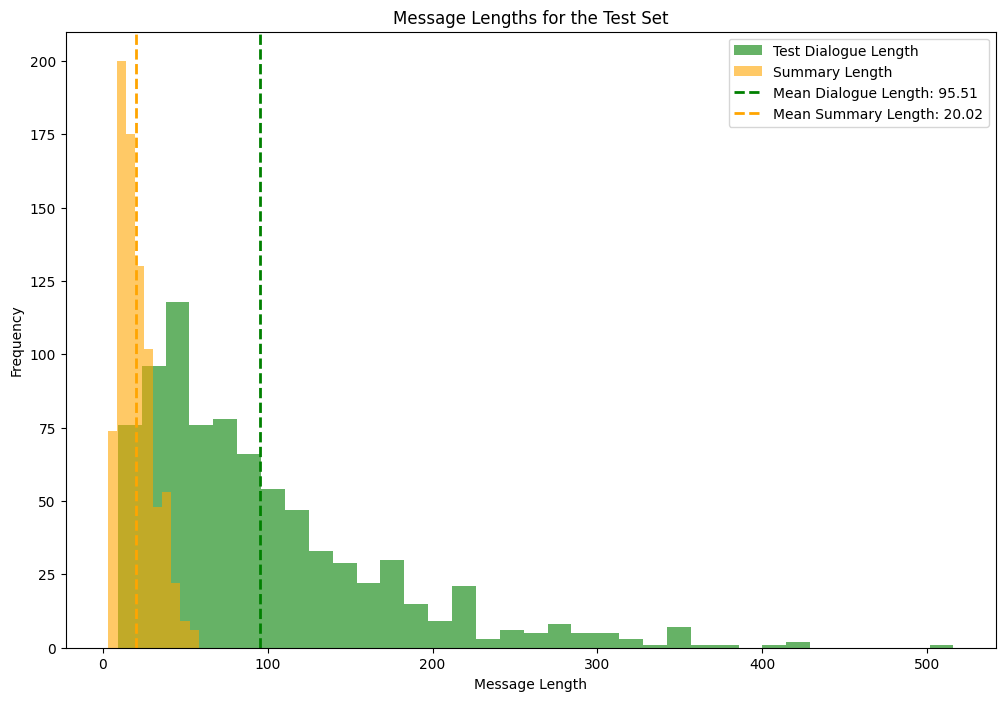

In [33]:
test_dialogue_length = test['dialogue'].apply(lambda x: len(x.split()))  # Length in words
test_summary_length = test['summary'].apply(lambda x: len(x.split()))    # Length in words

plt.figure(figsize=(12, 8))
test_dialogue_length.plot(bins=35, kind='hist', color='green', 
                          label='Test Dialogue Length', alpha=0.6)
test_summary_length.plot(kind='hist', color='orange', 
                          label='Summary Length', alpha=0.6)

# Add mean lines
mean_dialogue_length = test_dialogue_length.mean()
mean_summary_length = test_summary_length.mean()

plt.axvline(mean_dialogue_length, color='green', linestyle='dashed', linewidth=2, label=f'Mean Dialogue Length: {mean_dialogue_length:.2f}')
plt.axvline(mean_summary_length, color='orange', linestyle='dashed', linewidth=2, label=f'Mean Summary Length: {mean_summary_length:.2f}')

plt.legend()
plt.xlabel("Message Length")
plt.title("Message Lengths for the Test Set")

From these histograms, it looks like the lengths of dialogues and summaries across the three datasets are similarly distributed. On average, dialogues are about 93 words long, while summaries are around 20 words. 

### Data Cleaning

In [34]:
# Adjust pandas display options to view full message
pd.set_option('display.max_colwidth', None)  
train.tail()

,id,dialogue,summary
14727,13863028,"Romeo: You are on my ‘People you may know’ list.\nGreta: Ah, maybe it is because of the changed number of somebody’s?\nGreta: I don’t know you?\nRomeo: This might be the beginning of a beautiful relationship\nRomeo: How about adding me on your friend list and talk a bit?\nGreta: No.\nRomeo: Okay I see.",Romeo is trying to get Greta to add him to her friend list but she refuses.
14728,13828570,"Theresa: <file_photo>\r\nTheresa: <file_photo>\r\nTheresa: Hey Louise, how are u?\r\nTheresa: This is my workplace, they always give us so much food here 😊\r\nTheresa: Luckily they also offer us yoga classes, so all the food isn't much of a problem 😂\r\nLouise: Hey!! 🙂 \r\nLouise: Wow, that's awesome, seems great 😎 Haha\r\nLouise: I'm good! Are you coming to visit Stockholm this summer? 🙂\r\nTheresa: I don't think so :/ I need to prepare for Uni.. I will probably attend a few lessons this winter\r\nLouise: Nice! Do you already know which classes you will attend?\r\nTheresa: Yes, it will be psychology :) I want to complete a few modules that I missed :)\r\nLouise: Very good! Is it at the Uni in Prague?\r\nTheresa: No, it will be in my home town :)\r\nLouise: I have so much work right now, but I will continue to work until the end of summer, then I'm also back to Uni, on the 26th September!\r\nTheresa: You must send me some pictures, so I can see where you live :) \r\nLouise: I will, and of my cat and dog too 🤗\r\nTheresa: Yeeeesss pls :)))\r\nLouise: 👌👌\r\nTheresa: 🐱💕","Theresa is at work. She gets free food and free yoga classes. Theresa won't go to visit Louise in Stockholm, because she will prepare for university psychology lessons. She'll be back at uni on 26th September."
14729,13819050,"John: Every day some bad news. Japan will hunt whales again\r\nErica: Yes, I've read this. It's very upsetting\r\nJohn: Cruel Japanese\r\nFaith: I think this is a racist remark. Because Island and Norways has never joined this international whaling agreement\r\nErica: really? I haven't known, everybody is so outraged by Japan\r\nFaith: sure, European hypocrisy \r\nJohn: not entirely. Scandinavians don't use the nets that Japanese use, so Norway and Island kill much less specimens that Japan will\r\nFaith: oh, it's much more complex than one may expect\r\nJohn: True, but the truth is, that all of them should stop\r\nJohn: and this decision is a step back\r\nFaith: yes, this is worrying\r\nErica: And it seems that the most important whaling countries are out of the agreement right now\r\nFaith: yes, seems so\r\nJohn: Just like USA leaving the Paris Agreement",Japan is going to hunt whales again. Island and Norway never stopped hunting them. The Scandinavians kill fewer whales than the Japanese.
14730,13828395,"Jennifer: Dear Celia! How are you doing?\r\nJennifer: The afternoon with the Collins was very pleasant, nice folks, but we missed you.\r\nJennifer: But I appreciate your consideration for Peter.\r\nCelia: My dear Jenny! It turns out that my decision not to come, though I wanted so much to see you again and Peter and the Collins, was right. Yesterday it all developed into a full bore cold. Sh.....\r\nCelia: All symptoms like in a text book.\r\nCelia: Luckily it's contagious only on the first 2, 3 days, so when we meet next week it should be alright.\r\nCelia: Thanks for asking! Somehow for all of us Peter comes first now.\r\nJennifer: That's too bad. Poor you...\r\nJennifer: I'll be driving to FR, do you want me to bring you sth? It's on my way.\r\nCelia: Thank you dear! I was at the pharmacy yesterday and had done my shopping the day before.\r\nCelia: You'd better still stay away from me in case I'm still contagious\r\nJennifer: Right. So I'll only leave a basket on your terrace. Are you in bed?\r\nCelia: Goodness me - not! Actually working at the desk. A long overdue commission.\r\nJennifer: OK I won't disturb you.\r\nCelia: What basket??\r\nJennifer: If you can work it can't be that bad.\r\nJennifer: Maria b

Now that we have a better grasp of what the dialogues and summaries look like, we’ve noticed some emojis that we should remove to cut down on noise in our model. We'll also get rid of any tags and the special characters \r and \n.

In [36]:
def clean_text(text):
    
    clean = re.compile('<.*?>')        # Remove Tags
    clean = re.sub(clean, '', text)

    clean = '\n'.join([line for line in clean.split('\n') if not re.match('.*:\s*$', line)])  # Remove empty lines
    clean = re.sub(r'[^\x00-\x7F]+', '', clean)  #non-ASCII characters (includes emojis)
    # Remove \n and \r
    # clean = re.sub(r'\n', ' ', clean)  #This lowered performance
    # clean = re.sub(r'\r', ' ', clean) 
    return clean

In [37]:
train['dialogue'] = train['dialogue'].apply(clean_text)
val['dialogue'] = val['dialogue'].apply(clean_text)
test['dialogue'] = test['dialogue'].apply(clean_text)
train['summary'] = train['summary'].apply(clean_text)
val['summary'] = val['summary'].apply(clean_text)
test['summary'] = test['summary'].apply(clean_text)

Let’s check out the same messages after we've cleaned them up:

In [38]:
train.tail()

,id,dialogue,summary
14727,13863028,"Romeo: You are on my People you may know list.\nGreta: Ah, maybe it is because of the changed number of somebodys?\nGreta: I dont know you?\nRomeo: This might be the beginning of a beautiful relationship\nRomeo: How about adding me on your friend list and talk a bit?\nGreta: No.\nRomeo: Okay I see.",Romeo is trying to get Greta to add him to her friend list but she refuses.
14728,13828570,"Theresa: Hey Louise, how are u?\r\nTheresa: This is my workplace, they always give us so much food here \r\nTheresa: Luckily they also offer us yoga classes, so all the food isn't much of a problem \r\nLouise: Hey!! \r\nLouise: Wow, that's awesome, seems great Haha\r\nLouise: I'm good! Are you coming to visit Stockholm this summer? \r\nTheresa: I don't think so :/ I need to prepare for Uni.. I will probably attend a few lessons this winter\r\nLouise: Nice! Do you already know which classes you will attend?\r\nTheresa: Yes, it will be psychology :) I want to complete a few modules that I missed :)\r\nLouise: Very good! Is it at the Uni in Prague?\r\nTheresa: No, it will be in my home town :)\r\nLouise: I have so much work right now, but I will continue to work until the end of summer, then I'm also back to Uni, on the 26th September!\r\nTheresa: You must send me some pictures, so I can see where you live :) \r\nLouise: I will, and of my cat and dog too \r\nTheresa: Yeeeesss pls :)))\r\nLouise: \r\nTheresa:","Theresa is at work. She gets free food and free yoga classes. Theresa won't go to visit Louise in Stockholm, because she will prepare for university psychology lessons. She'll be back at uni on 26th September."
14729,13819050,"John: Every day some bad news. Japan will hunt whales again\r\nErica: Yes, I've read this. It's very upsetting\r\nJohn: Cruel Japanese\r\nFaith: I think this is a racist remark. Because Island and Norways has never joined this international whaling agreement\r\nErica: really? I haven't known, everybody is so outraged by Japan\r\nFaith: sure, European hypocrisy \r\nJohn: not entirely. Scandinavians don't use the nets that Japanese use, so Norway and Island kill much less specimens that Japan will\r\nFaith: oh, it's much more complex than one may expect\r\nJohn: True, but the truth is, that all of them should stop\r\nJohn: and this decision is a step back\r\nFaith: yes, this is worrying\r\nErica: And it seems that the most important whaling countries are out of the agreement right now\r\nFaith: yes, seems so\r\nJohn: Just like USA leaving the Paris Agreement",Japan is going to hunt whales again. Island and Norway never stopped hunting them. The Scandinavians kill fewer whales than the Japanese.
14730,13828395,"Jennifer: Dear Celia! How are you doing?\r\nJennifer: The afternoon with the Collins was very pleasant, nice folks, but we missed you.\r\nJennifer: But I appreciate your consideration for Peter.\r\nCelia: My dear Jenny! It turns out that my decision not to come, though I wanted so much to see you again and Peter and the Collins, was right. Yesterday it all developed into a full bore cold. Sh.....\r\nCelia: All symptoms like in a text book.\r\nCelia: Luckily it's contagious only on the first 2, 3 days, so when we meet next week it should be alright.\r\nCelia: Thanks for asking! Somehow for all of us Peter comes first now.\r\nJennifer: That's too bad. Poor you...\r\nJennifer: I'll be driving to FR, do you want me to bring you sth? It's on my way.\r\nCelia: Thank you dear! I was at the pharmacy yesterday and had done my shopping the day before.\r\nCelia: You'd better still stay away from me in case I'm still contagious\r\nJennifer: Right. So I'll only leave a basket on your terrace. Are you in bed?\r\nCelia: Goodness me - not! Actually working at the desk. A long overdue commission.\r\nJennifer: OK I won't disturb you.\r\nCelia: What basket??\r\nJennifer: If you can work it can't be that bad.\r\nJennifer: Maria brought plenty of cookies and I still had my linzertorte, so we're g

# Preprocessing Data

In this step, we prepare the text data for the model by tokenizing it and ensuring it's in the right format. We're using a T5 tokenizer from the Hugging Face library, which converts text into tokens that the model can understand.

In [39]:
from datasets import Dataset

# Transforming dataframes into datasets
train_ds = Dataset.from_pandas(train)
test_ds = Dataset.from_pandas(test)
val_ds = Dataset.from_pandas(val)

train_ds

Dataset({
    features: ['id', 'dialogue', 'summary', '__index_level_0__'],
    num_rows: 14731
})

**Tokenizer**: Import the tokenizer using the model checkpoint "google/t5-small". This tokenizer is pre-trained and matches the model we will use for summarization.

In [20]:
#Tokenizer
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small" #T5
#checkpoint = 'facebook/bart-large-xsum' # Bart
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [21]:
# Uncomment this to visualizing the model's architecture
#print(model) 

**Preprocessing function**: This function is designed to prepare the input text (dialogue) and the target text (summary). We add a prefix ("summarize: ") to indicate the task and use the tokenizer to convert the text into tokenized sequences with a max length.

In [22]:
#Preprocessing function from Huggingface Transformers Doc

prefix = "summarize: "
def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

**Applying preprocessing**: We apply the preprocessing function to our training, testing, and validation datasets, removing unnecessary columns like id, dialogue, and summary from the original data. This step ensures that only the tokenized inputs and labels remain for the model to process.


In [23]:
#Showing the extra columns (features) to remove
tokenized_train = train_ds.map(preprocess_function, batched=True)
tokenized_train

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'dialogue', 'summary', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 14731
})

In [24]:
# Applying preprocess_function to the datasets
tokenized_train = train_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary', '__index_level_0__']) # Removing features

tokenized_test = test_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary']) 

tokenized_val = val_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary']) 


Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

**Data collator**: Finally, we use the *DataCollatorForSeq2Seq*, which helps batch the tokenized sequences for the model to process efficiently during training. This allows the model to handle multiple inputs at once, which speeds up training and optimize the use of the available computational resources. It will also takes care of padding the sequences to ensure they are of equal length within the batch. 

In [25]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

### Importing Evaluation Metric

In [43]:
import evaluate

rouge = evaluate.load("rouge")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

# Training

We’re ready to start training the model now! We’ll use the Hugging Face Seq2SeqTrainer for this:

**Loading the Model**: We load the pre-trained model (T5) using the checkpoint "google/t5-small".

In [27]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Training

We’re ready to start training the model now! We’ll use the Hugging Face Seq2SeqTrainer for this:

**Loading the Model**: We load the pre-trained model (T5) using the checkpoint "google/t5-small".

In [44]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

**Training Arguments**: We define a set of training hyperparameters that control how the model is trained in Seq2SeqTrainingArguments.

We've made a few adjustments to the official documentation to address limited memory issues:
1. We reduced the batch size, which directly decreases the memory required per batch during training.
1. We implemented gradient accumulation, allowing us to process multiple smaller batches before updating the weights. This approach simulates a larger batch size without requiring as much memory.

In [28]:
training_args = Seq2SeqTrainingArguments(
    output_dir="t5_samsum",#This specifies where to save the model after training
    eval_strategy="epoch", #The model will evaluate after each training epoch.
    learning_rate=2e-5,    #We set a low learning rate for fine-tuning to avoid drastic changes to the pre-trained weights.
    per_device_train_batch_size=4,   # Using a smaller batch size
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,   # Accumulate gradients over 2 steps
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,    #The model will go through the training data 4 times (4 epochs)
    predict_with_generate=True,
    fp16=True,
    report_to="none",       # disable wandb reporting
)

**Trainer Setup**: Next, we set up the Seq2SeqTrainer, which handles the training loop for us. Pass the training arguments to Seq2SeqTrainer along with the model, dataset, tokenizer, data collator, and compute_metrics function.

In [29]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


**Finetune the Model**: Finally, we start the training process with trainer.train(). The model will go through the training dataset, learn from it, and evaluate its performance after each epoch using the validation set.

In [30]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.280400,1.867547,0.396500,0.172600,0.331100,0.331100,16.040300
2,2.043000,1.821636,0.401800,0.176100,0.335200,0.334900,16.311700
3,2.004700,1.801375,0.410000,0.182700,0.343900,0.343800,16.308100
4,1.981400,1.797182,0.409900,0.183800,0.344400,0.344500,16.380200


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated.

TrainOutput(global_step=3684, training_loss=2.050884077007944, metrics={'train_runtime': 1578.5991, 'train_samples_per_second': 37.327, 'train_steps_per_second': 2.334, 'total_flos': 5165583135277056.0, 'train_loss': 2.050884077007944, 'epoch': 4.0})

In [31]:
results = trainer.evaluate(tokenized_test)
print(results)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.8204271793365479, 'eval_rouge1': 0.4042, 'eval_rouge2': 0.166, 'eval_rougeL': 0.332, 'eval_rougeLsum': 0.3323, 'eval_gen_len': 16.6142, 'eval_runtime': 38.3871, 'eval_samples_per_second': 21.335, 'eval_steps_per_second': 2.683, 'epoch': 4.0}


In [32]:
# Save model to directory
directory = "/kaggle/t5_finetuned_samsum"
trainer.save_model(directory)

# Save model tokenizer & create Summarization Pipeline
tokenizer.save_pretrained(directory)
#summarizer = pipeline('summarization', model = model, tokenizer = tokenizer)

('/kaggle/t5_finetuned_samsum/tokenizer_config.json',
 '/kaggle/t5_finetuned_samsum/special_tokens_map.json',
 '/kaggle/t5_finetuned_samsum/spiece.model',
 '/kaggle/t5_finetuned_samsum/added_tokens.json',
 '/kaggle/t5_finetuned_samsum/tokenizer.json')

In [33]:
summarizer = pipeline('summarization', model = model, tokenizer = tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [39]:
test.head()

,id,dialogue,summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him \nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye",Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! There are some of his stand-ups on youtube.\r\nEric: Gr8! I'll watch them now!\r\nRob: Me too!\r\nEric: MACHINE!\r\nRob: MACHINE!\r\nEric: TTYL?\r\nRob: Sure :),Eric and Rob are going to watch a stand-up on youtube.
2,13680171,"Lenny: Babe, can you help me with something?\r\nBob: Sure, what's up?\r\nLenny: Which one should I pick?\r\nBob: Send me photos\r\nBob: I like the first ones best\r\nLenny: But I already have purple trousers. Does it make sense to have two pairs?\r\nBob: I have four black pairs :D :D\r\nLenny: yeah, but shouldn't I pick a different color?\r\nBob: what matters is what you'll give you the most outfit options\r\nLenny: So I guess I'll buy the first or the third pair then\r\nBob: Pick the best quality then\r\nLenny: ur right, thx\r\nBob: no prob :)",Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.
3,13729438,"Will: hey babe, what do you want for dinner tonight?\r\nEmma: gah, don't even worry about it tonight\r\nWill: what do you mean? everything ok?\r\nEmma: not really, but it's ok, don't worry about cooking though, I'm not hungry\r\nWill: Well what time will you be home?\r\nEmma: soon, hopefully\r\nWill: you sure? Maybe you want me to pick you up?\r\nEmma: no no it's alright. I'll be home soon, i'll tell you when I get home. \r\nWill: Alright, love you. \r\nEmma: love you too.",Emma will be home soon and she will let Will know.
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, just back! Btw are you free for diner the 19th?\r\nOllie: nope!\r\nJane: and the 18th?\r\nOllie: nope, we have this party and you must be there, remember?\r\nJane: oh right! i lost my calendar.. thanks for reminding me\r\nOllie: we have lunch this week?\r\nJane: with pleasure!\r\nOllie: friday?\r\nJane: ok\r\nJane: what do you mean "" we don't have any more whisky!"" lol..\r\nOllie: what!!!\r\nJane: you just call me and the all thing i heard was that sentence about whisky... what's wrong with you?\r\nOllie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol\r\nJane: dont' worry, we'll check on friday.\r\nOllie: don't forget to bring some sun with you\r\nJane: I can't wait to be in Morocco..\r\nOllie: enjoy and see you friday\r\nJane: sorry Ollie, i'm very busy, i won't have time for lunch tomorrow, but may be at 6pm after my courses?this trip to Morocco was so nice, but time consuming!\r\nOllie: ok for tea!\r\nJane: I'm on my way..\r\nOllie: tea is ready, did you bring the pastries?\r\nJane: I already ate them all... see you in a minute\r\nOllie: ok",Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm.


In [62]:
generated_summaries = summarizer(test["dialogue"].tolist()[:5], max_length=50, min_length=20, do_sample=True)
print(generated_summaries)

[{'summary_text': "Amanda has Betty's number. Lemme check Amanda's. He called her last time she was at the park."}, {'summary_text': "Rob will watch some of Eric's stand-ups on youtube. They'll watch them now."}, {'summary_text': 'Bob wants Lenny to help him with her outfit choices. Bob will buy the first or the third pair. He will pick the best quality.'}, {'summary_text': 'Emma will be home soon. She will pick Emma up when she gets home. Emma will tell her when she get home.'}, {'summary_text': 'Ollie and Jane are in Warsaw for dinner the 19th and the 18th. They have lunch this week. They will check on friday.'}]


In [63]:
generated_summary_texts = [summary['summary_text'] for summary in generated_summaries]
generated_summaries_df = pd.DataFrame({'Generated Summary': generated_summary_texts})
generated_summaries_df
test_top = test[:5]
combined_df = pd.concat([test_top.reset_index(drop=True), generated_summaries_df.reset_index(drop=True)], axis=1)

combined_df

,id,dialogue,summary,Generated Summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him \nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye",Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.,Amanda has Betty's number. Lemme check Amanda's. He called her last time she was at the park.
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! There are some of his stand-ups on youtube.\r\nEric: Gr8! I'll watch them now!\r\nRob: Me too!\r\nEric: MACHINE!\r\nRob: MACHINE!\r\nEric: TTYL?\r\nRob: Sure :),Eric and Rob are going to watch a stand-up on youtube.,Rob will watch some of Eric's stand-ups on youtube. They'll watch them now.
2,13680171,"Lenny: Babe, can you help me with something?\r\nBob: Sure, what's up?\r\nLenny: Which one should I pick?\r\nBob: Send me photos\r\nBob: I like the first ones best\r\nLenny: But I already have purple trousers. Does it make sense to have two pairs?\r\nBob: I have four black pairs :D :D\r\nLenny: yeah, but shouldn't I pick a different color?\r\nBob: what matters is what you'll give you the most outfit options\r\nLenny: So I guess I'll buy the first or the third pair then\r\nBob: Pick the best quality then\r\nLenny: ur right, thx\r\nBob: no prob :)",Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.,Bob wants Lenny to help him with her outfit choices. Bob will buy the first or the third pair. He will pick the best quality.
3,13729438,"Will: hey babe, what do you want for dinner tonight?\r\nEmma: gah, don't even worry about it tonight\r\nWill: what do you mean? everything ok?\r\nEmma: not really, but it's ok, don't worry about cooking though, I'm not hungry\r\nWill: Well what time will you be home?\r\nEmma: soon, hopefully\r\nWill: you sure? Maybe you want me to pick you up?\r\nEmma: no no it's alright. I'll be home soon, i'll tell you when I get home. \r\nWill: Alright, love you. \r\nEmma: love you too.",Emma will be home soon and she will let Will know.,Emma will be home soon. She will pick Emma up when she gets home. Emma will tell her when she get home.
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, just back! Btw are you free for diner the 19th?\r\nOllie: nope!\r\nJane: and the 18th?\r\nOllie: nope, we have this party and you must be there, remember?\r\nJane: oh right! i lost my calendar.. thanks for reminding me\r\nOllie: we have lunch this week?\r\nJane: with pleasure!\r\nOllie: friday?\r\nJane: ok\r\nJane: what do you mean "" we don't have any more whisky!"" lol..\r\nOllie: what!!!\r\nJane: you just call me and the all thing i heard was that sentence about whisky... what's wrong with you?\r\nOllie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol\r\nJane: dont' worry, we'll check on friday.\r\nOllie: don't forget to bring some sun with you\r\nJane: I can't wait to be in Morocco..\r\nOllie: enjoy and see you friday\r\nJane: sorry Ollie, i'm very busy, i won't have time for lunch tomorrow, but may be at 6pm after my courses?this trip to Morocco was so nice, but time consuming!\r\nOllie: ok for tea!\r\nJane: I'm on my way..\r\nOllie: tea is ready, did you bring the pastries?\r\nJane: I already ate them all... see you in a minute\r\nOllie: ok",Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Frid

# Fine-tuning a Bart Model

In [45]:
#Tokenizer Set Up
from transformers import BartTokenizer, BartForConditionalGeneration 
checkpoint = 'facebook/bart-large-xsum' 
tokenizer = BartTokenizer.from_pretrained(checkpoint)

prefix = "summarize: "
def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary', '__index_level_0__']) # Removing features

tokenized_test = test_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary']) 

tokenized_val = val_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary']) 


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [46]:
model = BartForConditionalGeneration.from_pretrained(checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [26]:
print(model)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In [47]:
training_args = Seq2SeqTrainingArguments(
    output_dir="bart_samsum", 
    eval_strategy="epoch", 
    learning_rate=2e-5,    
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,   
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,   
    predict_with_generate=True,
    fp16=True,
    report_to="none",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,1.380400,1.404985,0.535800,0.285500,0.440600,0.440600,30.075800
2,0.834500,1.519923,0.543300,0.292700,0.446300,0.445900,30.916900
3,0.695200,1.588842,0.545700,0.293200,0.448900,0.448700,31.014700


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a G

TrainOutput(global_step=7364, training_loss=1.010500245350719, metrics={'train_runtime': 6505.4182, 'train_samples_per_second': 9.058, 'train_steps_per_second': 1.132, 'total_flos': 3.490109052191539e+16, 'train_loss': 1.010500245350719, 'epoch': 3.9989139288623403})

In [48]:
results = trainer.evaluate(tokenized_test)
print(results)

{'eval_loss': 1.630325198173523, 'eval_rouge1': 0.5275, 'eval_rouge2': 0.2769, 'eval_rougeL': 0.4375, 'eval_rougeLsum': 0.4371, 'eval_gen_len': 30.6386, 'eval_runtime': 323.5713, 'eval_samples_per_second': 2.531, 'eval_steps_per_second': 0.634, 'epoch': 3.9989139288623403}


In [49]:
summarizer = pipeline('summarization', model = model, tokenizer = tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [50]:
generated_summaries = summarizer(test["dialogue"].tolist()[:5], max_length=50, min_length=20, do_sample=True)
generated_summary_texts = [summary['summary_text'] for summary in generated_summaries]
generated_summaries_df = pd.DataFrame({'Generated Summary': generated_summary_texts})
generated_summaries_df
test_top = test[:5]
combined_df = pd.concat([test_top.reset_index(drop=True), generated_summaries_df.reset_index(drop=True)], axis=1)

combined_df

,id,dialogue,summary,Generated Summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him \nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye",Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.,"Larry called Betty the last time Amanda and Hannah were at the park. Hannah doesn't know him well, but Amanda thinks he's nice. Hannah will text him about it."
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! There are some of his stand-ups on youtube.\r\nEric: Gr8! I'll watch them now!\r\nRob: Me too!\r\nEric: MACHINE!\r\nRob: MACHINE!\r\nEric: TTYL?\r\nRob: Sure :),Eric and Rob are going to watch a stand-up on youtube.,Eric and Rob are watching a Russian comedian's stand-up on youtube. They find it funny.
2,13680171,"Lenny: Babe, can you help me with something?\r\nBob: Sure, what's up?\r\nLenny: Which one should I pick?\r\nBob: Send me photos\r\nBob: I like the first ones best\r\nLenny: But I already have purple trousers. Does it make sense to have two pairs?\r\nBob: I have four black pairs :D :D\r\nLenny: yeah, but shouldn't I pick a different color?\r\nBob: what matters is what you'll give you the most outfit options\r\nLenny: So I guess I'll buy the first or the third pair then\r\nBob: Pick the best quality then\r\nLenny: ur right, thx\r\nBob: no prob :)",Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.,Lenny will buy the first or the third pair of purple trousers. Bob has four black pairs.
3,13729438,"Will: hey babe, what do you want for dinner tonight?\r\nEmma: gah, don't even worry about it tonight\r\nWill: what do you mean? everything ok?\r\nEmma: not really, but it's ok, don't worry about cooking though, I'm not hungry\r\nWill: Well what time will you be home?\r\nEmma: soon, hopefully\r\nWill: you sure? Maybe you want me to pick you up?\r\nEmma: no no it's alright. I'll be home soon, i'll tell you when I get home. \r\nWill: Alright, love you. \r\nEmma: love you too.",Emma will be home soon and she will let Will know.,Emma doesn't want to cook dinner tonight. She will tell Will when she gets home.
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, just back! Btw are you free for diner the 19th?\r\nOllie: nope!\r\nJane: and the 18th?\r\nOllie: nope, we have this party and you must be there, remember?\r\nJane: oh right! i lost my calendar.. thanks for reminding me\r\nOllie: we have lunch this week?\r\nJane: with pleasure!\r\nOllie: friday?\r\nJane: ok\r\nJane: what do you mean "" we don't have any more whisky!"" lol..\r\nOllie: what!!!\r\nJane: you just call me and the all thing i heard was that sentence about whisky... what's wrong with you?\r\nOllie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol\r\nJane: dont' worry, we'll check on friday.\r\nOllie: don't forget to bring some sun with you\r\nJane: I can't wait to be in Morocco..\r\nOllie: enjoy and see you friday\r\nJane: sorry Ollie, i'm very busy, i won't have time for lunch tomorrow, but may be at 6pm after my courses?this trip to Morocco was so nice, but time consuming!\r\nOllie: ok for tea!\r\nJane: I'm on my way..\r\nOllie: tea is ready, did you bring the pastries?\r\nJane: I already ate them all... see you in a minute\r\nOllie: ok",Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunc

In [51]:
# Save model to directory
directory = "/kaggle/bart_finetuned_samsum"
trainer.save_model(directory)

# Save model tokenizer & create Summarization Pipeline
tokenizer.save_pretrained(directory)
#summarizer = pipeline('summarization', model = model, tokenizer = tokenizer)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}


('/kaggle/bart_finetuned_samsum/tokenizer_config.json',
 '/kaggle/bart_finetuned_samsum/special_tokens_map.json',
 '/kaggle/bart_finetuned_samsum/vocab.json',
 '/kaggle/bart_finetuned_samsum/merges.txt',
 '/kaggle/bart_finetuned_samsum/added_tokens.json')

# References: 
* Summarization Tutorial from Hugging Face: [link](http://https://huggingface.co/docs/transformers/en/tasks/summarization)
* T5 Documentation on Hugging Face: [link](http://https://huggingface.co/docs/transformers/v4.15.0/en/model_doc/t5#transformers.T5Model)
* Luis's Notebook: [link](http://https://www.kaggle.com/code/lusfernandotorres/text-summarization-with-large-language-models/notebook)
* Fares's NLP tutorial: [link](http://https://www.kaggle.com/code/faressayah/natural-language-processing-nlp-for-beginners#🔍-Exploratory-Data-Analysis-(EDA))
* Hakim11's Notebook: [link](http://https://www.kaggle.com/code/hakim11/fine-tune-llm-for-dialogue-summarization#Model-Architecture)